Задача.

Сделать прогноз продаж среднего чека по данным интернет-магазина детских товаров на 05.2017 по группам: 
 
A) Группа часто покупающих (4 и более покупок) и которые последний раз покупали не так давно.  
B) Группа часто покупающих (4 и более покупок), но которые не покупали уже значительное время(больше 30 и меньше 60)
C) Пользователи с 1 покупой за все время 
 
В итоге, сравнить прогноз с фактом на апрель 2017 и оценить грубо разлет по данным.

In [124]:
import pandas as pd
from datetime import datetime
import matplotlib

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import numpy as np

In [125]:
matplotlib.rcParams['figure.figsize'] =  [12.0, 8.0]

In [126]:
to_datetime = lambda d: datetime.strptime(d, '%d.%m.%Y')

In [127]:
df_0 = pd.read_csv('orders_20190822.csv', sep=';', encoding='utf-8', decimal = ',', converters={'o_date': to_datetime})

In [128]:
#изменим название price на более точное название sales
df_0.columns = ['sales' if x=='price' else x for x in df_0.columns]

In [129]:
#сделаем дату нашим индексом 
df_0 = df_0.set_index('o_date')

**Поиск аномалий**

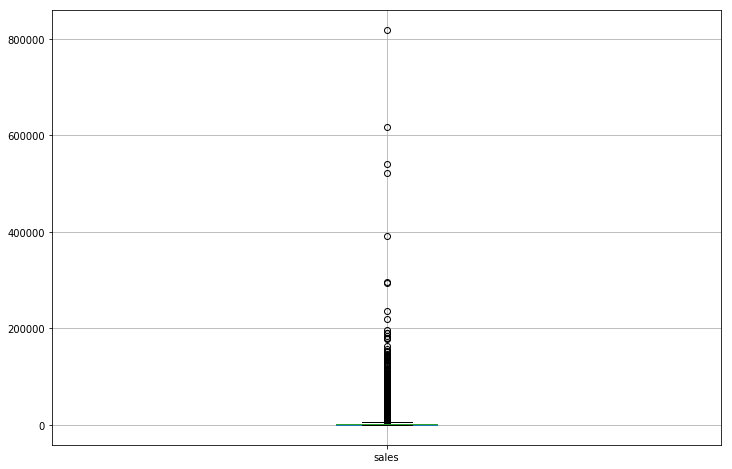

In [206]:
df_0.boxplot(column="sales")

Очевидно, что есть сильные аномалии по сумме закупок свыше 150000 рублей, которые не характерны для всей совокупности. Избавимся от этих выбросов, чтобы они не искажали результаты RFM анализа.

In [207]:
df = df_0.loc[(df_0['sales'] <=150000)]

**Выделим тренировочную и тестовую выборку**

In [208]:
train = df[:'2017-04-30'] 

In [209]:
test= df['2017-05-01':'2017-05-31']

***Recency - расчет давности покупок***

In [210]:
rec_dict ={}
latest_date = train.tail(1).index[0] #последняя дата покупки 

for i, v in train.iterrows():
    difference_time = latest_date - i
    user_id = v['user_id']
    
    if difference_time.days <=30:
        rec_dict[user_id] = 1
    if (difference_time.days >30 and difference_time.days <=60 and rec_dict.get(user_id)==None):
        rec_dict[user_id] = 2
    elif (difference_time.days >60 and rec_dict.get(user_id)==None):
        rec_dict[user_id] = 3

***Frequency - расчет количествы покупок на одного клиента или их частоты***

In [211]:
rfm_df_count = train[['user_id', 'sales']].groupby('user_id').count().reset_index()

In [212]:
freq_dict = {} #количество всех покупок по каждому уникальному пользователю 
for i, v in rfm_df_count.iterrows():
    user_id = v['user_id'] 
    count_user = v['sales'] 
    if count_user ==1:
        freq_dict[user_id ] = '1'
    elif (count_user > 1 and count_user  <4):
        freq_dict[user_id ] = '2'
    else:
        freq_dict[user_id ] = '3'

In [213]:
rfm_df = train[['user_id', 'sales']].groupby('user_id').sum().reset_index()

In [214]:
#Добавляем колонки monetary, recency, frequency в новый dataframe
rfm_df['recency'] = rfm_df['user_id'].map(rec_dict)
rfm_df['freq'] = rfm_df['user_id'].map(freq_dict)

In [215]:
#Соединяем комбинации RFM в отдельный столбец
rfm_df['rf'] = rfm_df.recency.astype(str) + rfm_df.freq

In [216]:
rfm_df.head()

,user_id,sales,recency,freq,rf
0,0,494.2,3,1,31
1,1,2799.3,3,1,31
2,76,1248.1,3,1,31
3,90,1190.0,3,1,31
4,91,3868.9,3,2,32


**Первая группа = 32**

Группа часто покупающих (4 и более покупок) и которые последний раз покупали не так давно. 

**Вторая группа = 23**

Группа часто покупающих, но которые не покупали уже значительное время

**Третья группа = 1**

Одна покупка за все время 

In [139]:
#Найдем id пользователей по каждой группе

In [300]:
group_1 = rfm_df['user_id'].loc[(rfm_df['rf']=='32')].values
group_2 = rfm_df['user_id'].loc[(rfm_df['rf']=='23')].values
group_3 = rfm_df['user_id'].loc[(rfm_df['freq']=='1')].values

In [141]:
#Возьмем объем продаж по найденным id пользователей по каждой группе 

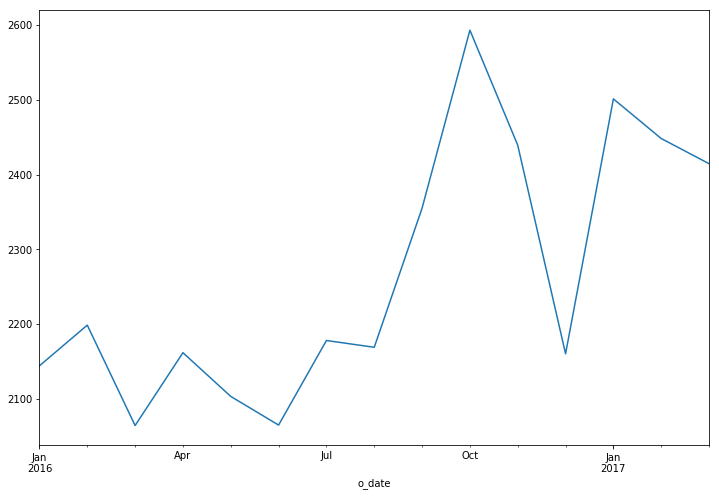

In [302]:
train_group_1 = train['sales'].loc[train['user_id'].isin(group_1)] 
train_group_1 = train_group_1.resample('M').mean()
train_group_1.plot()

In [303]:
train_group_2= train['sales'].loc[train['user_id'].isin(group_2)]
train_group_2=train_group_2.resample('M').mean()
train_group_2

o_date
2017-03-31    3099.410061
Freq: M, Name: sales, dtype: float64

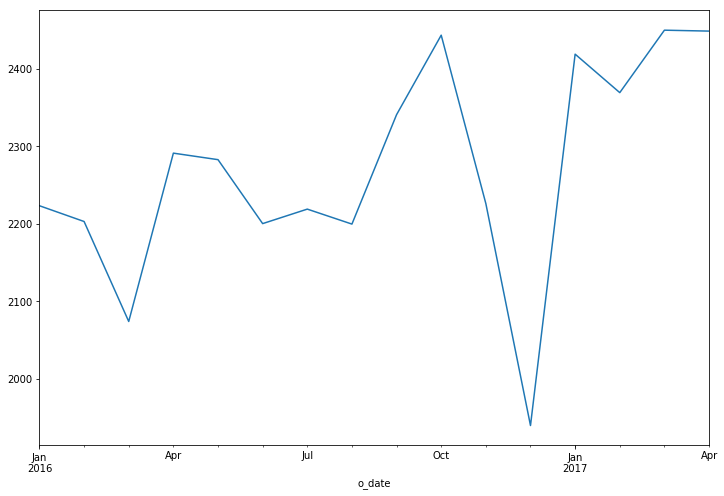

In [304]:
train_group_3 = train['sales'].loc[train['user_id'].isin(group_3)]
train_group_3 = train_group_3 .resample('M').mean()
train_group_3.plot()
plt.show()

Выделим тестовые выборки для каждой группы

In [307]:
test_group_1 = test['sales'].loc[test['user_id'].isin(group_1)]
test_group_2= test['sales'].loc[test['user_id'].isin(group_2)]
test_group_3 = test['sales'].loc[test['user_id'].isin(group_3)] 

In [308]:
len(test_group_1), len(test_group_2), len(test_group_3)

(5181, 37, 7925)

**Прогноз продаж среднего чека на 1 пользователя по каждой группе**

Для прогноза продаж будем использовать метод скользящей средней. 

**Группа 1 - часто покупающих (4 и более покупок) и которые последний раз покупали не так давно.**

In [309]:
#Возьмем данные с конца июля 2016 для скользящего окна
rolling_window = len(train_group_1[6:])

In [359]:
train_mean_forcast_g1 = train_group_1.rolling(rolling_window).mean().iloc[-1].round(1)

In [326]:
diff_group_1 = test_group_1.mean() - train_mean_forcast_g1 

In [327]:
diff_group_1

-169.03640939576144

**Группа 2 - часто покупающих, но которые не покупали уже значительное время**

In [322]:
len(train_group_2)

1

In [358]:
train_mean_forcast_g2 = train_group_2[0].round(1)

Так как у нас всего 1 наблюдение в этой группе, то мы предпологаем, что среднее значение за прошлый период, будет равно в будущем

In [335]:
diff_group_2 = test_group_2.mean() - train_mean_forcast_g2

In [336]:
diff_group_2

-908.2776285431869

**Группа 3 - Одна покупка за все время**

In [331]:
#Возьмем данные с конца июля 2016 для скользящего окна
rolling_window3 = len(train_group_3[6:])

In [356]:
train_mean_forcast_g3 = train_group_3.rolling(rolling_window).mean().iloc[-1].round(1)

In [333]:
diff_group_3 = test_group_3.mean() - train_mean_forcast_g3 

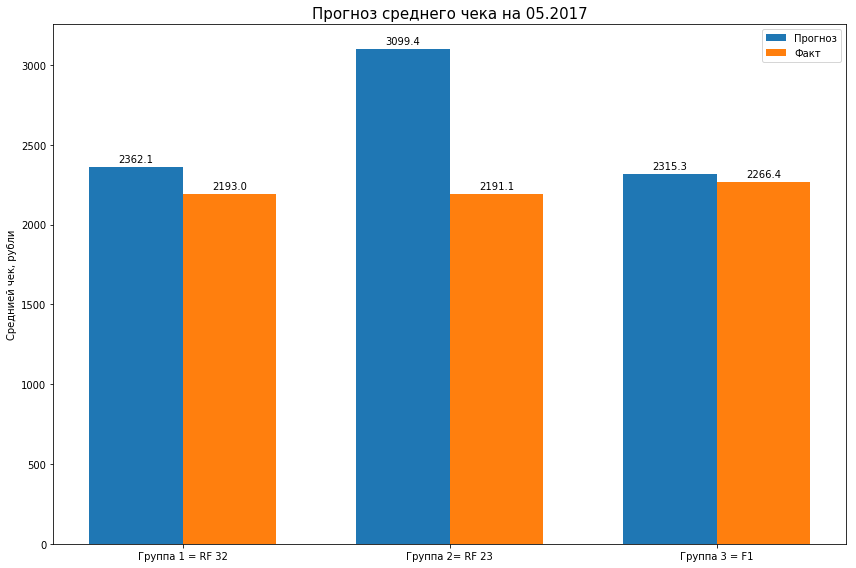

In [369]:
labels = ['Группа 1 = RF 32', 'Группа 2= RF 23', 'Группа 3 = F1']
train_means = [train_mean_forcast_g1, train_mean_forcast_g2, train_mean_forcast_g3]
test_means = [round(test_group_1.mean(),1), round(test_group_2.mean(),1), round(test_group_3.mean(),1)]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, train_means, width, label='Прогноз')
rects2 = ax.bar(x + width/2, test_means, width, label='Факт')

# Добавим название и легенду
ax.set_ylabel('Среднией чек, рубли')
ax.set_title('Прогноз среднего чека на 05.2017', fontsize = 15)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

#Покажим значения каждого столбца 
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
fig.tight_layout()
plt.show()

**Резюме**

По факту прогноз не сильно отличается. Дальше можно перейти к прознозу количества клиентов, чтобы можно было спрогнозировать объем продаж.